## This is the 2D testcase of the echoRD model
### New version for generic cases based on pre-defined macropore definitions

Make sure to have the dependencies numpy, pandas, scipy, matplotlib and echoRD installed.
This is the Python 3 version.

### Preamble

In [1]:
import numpy as np
import pandas as pd
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import scipy as sp
import matplotlib.pyplot as plt
import os, sys

In [3]:
#connect echoRD Tools
pathdir='../' #path to echoRD
lib_path = os.path.abspath(pathdir)
sys.path.append(lib_path)
import vG_conv as vG
from hydro_tools import plotparticles_t,hydroprofile,plotparticles_specht

In [4]:
try:
   import cPickle as pickle
except:
   import pickle


### Prepare echoRD

In [5]:
#connect to echoRD
import run_echoRD as rE
#connect and load project
[dr,mc,mcp,pdyn,cinf,vG]=rE.loadconnect(pathdir='../',mcinif='mcini_g63',experimental=True)
mc=rE.preproc_echoRD(mc, dr, mcp,'column.pickle')
runname='column'
mc.advectref='Shipitalo'

used predefined soil definitions
MODEL SETUP READY.
wrote mc to column.pickle


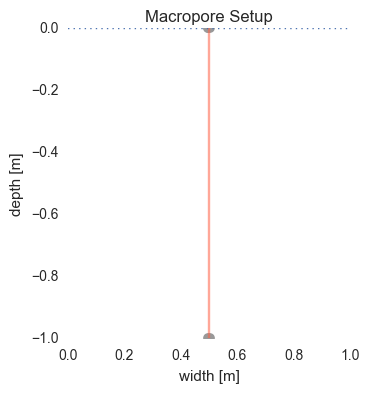

In [6]:
import macropore_ini as mpo
mpo.mac_plot(mc.macP,mc,'macs_'+runname+'.pdf')

In [7]:
mc.md_macdepth

array([ 1.])

In [8]:
mc.precf

'irr_g63.dat'

[12]


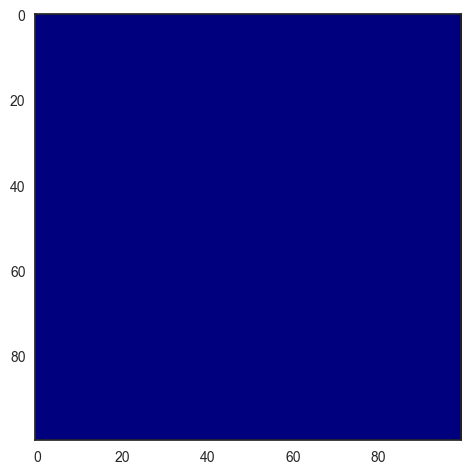

In [9]:
imshow(mc.soilgrid,interpolation=None,cmap='jet') 
print(np.unique(mc.soilgrid))

In [10]:
precTS=pd.read_csv(mc.precf, sep=',',skiprows=3)

In [11]:
precTS=pd.read_csv(mc.precf, sep=',',skiprows=3)
#debug only:
precTS.tstart-=340
precTS.tend-=340
precTS.intense=2.*0.063*60./1000.# intensity in m3/s
precTS

,tstart,tend,total,intense,conc
0,60,90060,0.0945,0.00756,0.000165


In [12]:
#use modified routines for binned retention definitions
mc.part_sizefac=500
mc.gridcellA=mc.mgrid.vertfac*mc.mgrid.latfac
mc.particleA=abs(mc.gridcellA.values)/(2*mc.part_sizefac) #assume average ks at about 0.5 as reference of particle size
mc.particleD=2.*np.sqrt(mc.particleA/np.pi)
mc.particleV=3./4.*np.pi*(mc.particleD/2.)**3.
mc.particleV/=np.sqrt(abs(mc.gridcellA.values)) #assume grid size as 3rd dimension
mc.particleD/=np.sqrt(abs(mc.gridcellA.values))
mc.particlemass=dr.waterdensity(np.array(20),np.array(-9999))*mc.particleV #assume 20°C as reference for particle mass
                                                                        #DEBUG: a) we assume 2D=3D; b) change 20°C to annual mean T?
mc=dr.ini_bins(mc)
mc=dr.mc_diffs(mc,np.max(np.max(mc.mxbin)))

In [13]:
#mc.inimf='./moisture/07_4_1_moist.dat'
[mc,particles,npart]=dr.particle_setup(mc)

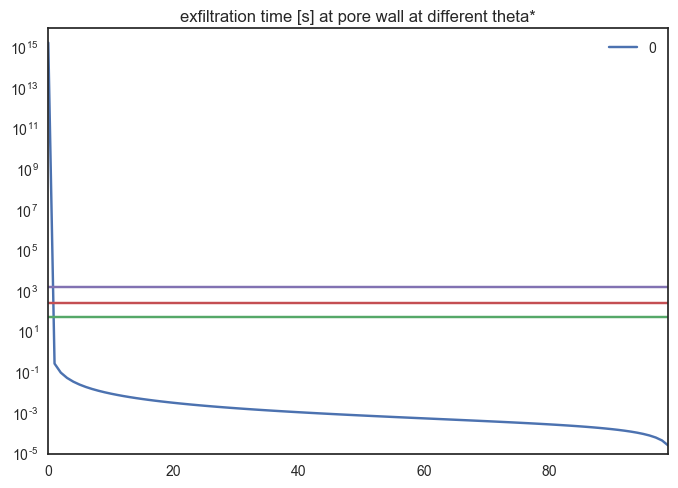

In [14]:
#non-particle setting dependent infiltration breakpoint
dummy=np.zeros((100,len(np.unique(mc.soilgrid))))
j=0
for soil in np.unique(mc.soilgrid)-1:
    #plot(i,(mc.theta100[100-i,4]/(mc.particleD*0.5))*mc.D100[i,4]+mc.ku100[i,4],'.') #q
    for i in np.arange(100):
        dummy[i,j]=pdyn.filmthick(mc.psi100[i,soil])/((mc.theta100[100-i,soil]/(mc.particleD*0.5))*mc.D100[i,soil]+mc.ku100[i,soil])
        #plot(i,((0.001*mc.particleD[0])/((mc.theta100[100-i,soil]/(mc.particleD*0.5))*mc.D100[i,soil]+mc.ku100[i,soil]))/60,'.') #time to infilt
        #plot(i,(0.5*mc.particleD[0])/mc.ku100[i,soil]/60,'.') #time to infilt
    j+=1

dummyD=pd.DataFrame(dummy.T)
#dummyD.index=mc.soilmatrix.type
#dummyD.T.iloc[:,8].plot()
dummyD.T.plot()
plot([0,100],[60,60],'-',label='1min')
plot([0,100],[300,300],'-',label='5min')
plot([0,100],[1800,1800],'-',label='30min')
yscale('log')
#legend(ncol=3)
title('exfiltration time [s] at pore wall at different theta*')

In [19]:
mc.soilmatrix

,no,ks,ts,tr,alpha,n,rho,z,type,m
0,1,5.833333e-05,0.417,0.020,13.800,1.592,1500.0,-2.3,sand,0.371859
1,2,1.696759e-05,0.401,0.035,11.500,1.474,1500.0,-2.3,loamySand,0.321574
2,3,7.194444e-06,0.412,0.041,6.800,1.322,1500.0,-2.3,sandyLoam,0.243570
3,4,1.888889e-06,0.434,0.027,9.000,1.220,1500.0,-2.3,loam,0.180328
4,5,3.666666e-06,0.486,0.015,4.800,1.211,1500.0,-2.3,siltLoam,0.174236
5,6,1.194446e-06,0.330,0.068,3.590,1.250,1500.0,-2.3,sandyClayLoam,0.200000
6,7,6.388889e-07,0.390,0.075,3.900,1.194,1500.0,-2.3,clayLoam,0.162479
7,8,4.166667e-07,0.432,0.040,3.100,1.151,1500.0,-2.3,siltyClayLoam,0.131190
8,9,3.333333e-07,0.321,0.109,3.400,1.168,1500.0,-2.3,sandyClay,0.143836
9,10,2.500040e-07,0.423,0.056,2.900,1.127,1500.0,-2.3,siltyClay,0.112689


In [16]:
#new reference
mc.maccon=np.where(mc.macconnect.ravel()>0)[0] #index of all connected cells
#mc.md_macdepth=np.abs(mc.md_macdepth)

In [17]:
#define bin assignment mode for infiltration particles
mc.LTEdef='instant'#'ks' #'instant' #'random'
mc.LTEmemory=mc.soilgrid.ravel()*0.

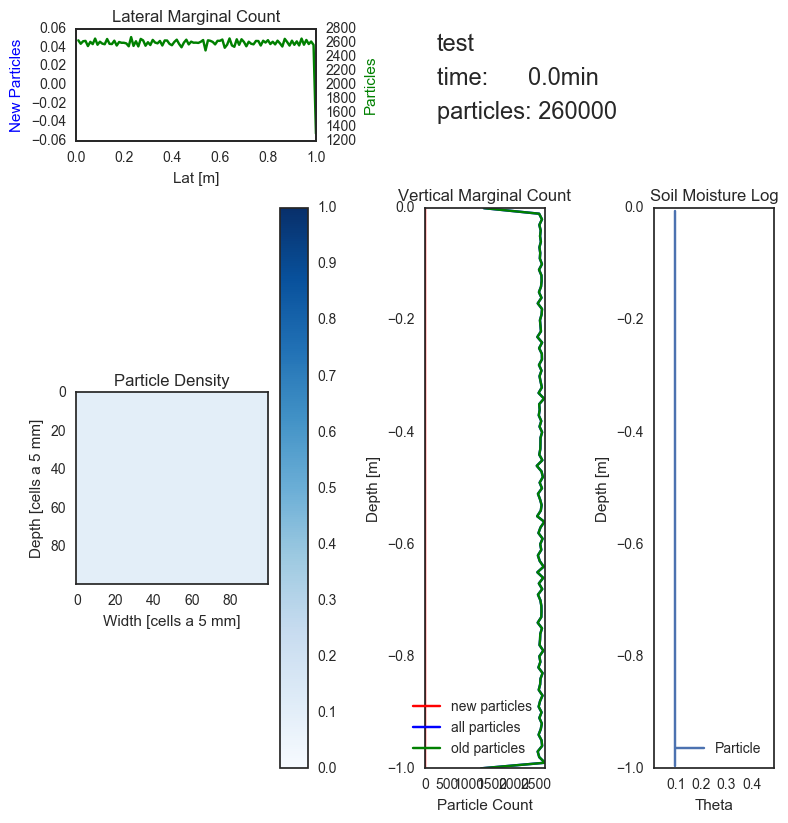

In [20]:
#mc.prects=False
mc.prects='column2'
mc.colref=False
#theta=mc.zgrid[:,1]*0.+0.273
#[mc,particles,npart]=rE.particle_setup_obs(theta,mc,vG,dr,pdyn)
[thS,npart]=pdyn.gridupdate_thS(particles.lat,particles.z,mc)
[A,B]=plotparticles_t(particles,thS/100.,mc,vG,store=True)

### Run Model

In [21]:
mc.LTEpercentile=70 #new parameter
particles.LTEbin=np.fmin(particles.LTEbin.values,len(mc.D)-1)

In [22]:
t_end=6.*3600.
saveDT=True

In [23]:
#1: MDA
#2: MED
#3: rand
infiltmeth='MDA'
#3: RWdiff
#4: Ediss
#exfiltmeth='RWdiff'
exfiltmeth='Ediss'
#5: film_uconst
#6: dynamic u
film=True
#7: maccoat1
#8: maccoat10
#9: maccoat100
macscale=1. #scale the macropore coating 
clogswitch=False
infiltscale=False#0.8


In [24]:
#mc.dt=0.11
#mc.splitfac=5
#pdyn.part_diffusion_binned_pd(particles,npart,thS,mc)

In [25]:

drained=pd.DataFrame(np.array([]))
leftover=0
output=60. #mind to set also in TXstore.index definition

dummy=np.floor(t_end/output)
#prepare store arrays
TSstore=np.zeros((int(dummy),np.shape(thS)[0],np.shape(thS)[1]))
NPstore=np.zeros((int(dummy),len(mc.zgrid[:,1])+1))
colnames=['part1','part2','part3','part4','part5']
TXstore=pd.DataFrame(np.zeros((int(dummy),len(colnames))),columns=colnames)
t=0.
#loop through plot cycles
for i in np.arange(dummy.astype(int)):
    #plot and store states
    plotparticles_specht(particles,mc,pdyn,vG,runname,t,i,saving=True,relative=False)
    [TXstore.iloc[i],NPstore[i,:]]=plotparticles_t(particles,thS/100.,mc,vG,runname,t,i,saving=True,store=True)
    #store thS
    TSstore[i,:,:]=thS
    [particles,npart,thS,leftover,drained,t]=rE.CAOSpy_rundx1(i*output,(i+1)*output,mc,pdyn,cinf,precTS,particles,leftover,drained,6.,splitfac=1,prec_2D=False,maccoat=macscale,saveDT=saveDT,clogswitch=clogswitch,infilt_method=infiltmeth,exfilt_method=exfiltmeth,film=film,infiltscale=infiltscale)
    
    if i/5.==np.round(i/5.):
        with open(''.join(['./results/Z',runname,'_Mstat.pick']),'wb') as handle:
            pickle.dump(pickle.dumps([pickle.dumps(particles),pickle.dumps([leftover,drained,t])]), handle, protocol=2)

    
    

'time: 69.5s  |  n_particles: 590507  |  precip: 424370  |  advect: 375864  |  exfilt: 79  |  mean v(adv): -0.00081988 m/s'

'time: 69.5s  |  n_particles now: 635151  |  leftover: 379723'

KeyboardInterrupt: 